<a href="https://colab.research.google.com/github/protocol-streams/querent-experimental/blob/main/Corpus%20to%20Graph_experiment_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.0.0/en_core_web_lg-3.0.0.tar.gz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.7/778.7 MB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 8.9 MB/s eta 0:00:00
  Created wheel for en-core-web-lg: filename=en_core_web_lg-3.0.0-py3-none-any.whl size=778750476 sha256=2081e28975d88fd8c4ee0b253b33a5909e4b007ff12517e9faae51bdbe5e0cd7
  Stored in directory: /root/.cache/pip/wheels/4d/30/74/df255edbc5dbeb5c2e0ce666ac4989fec3b3289552889d531a
Successfully built en-core-web-lg
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.2
    Uninstalling wasabi-1.1.2:
      Successfully uninstalled wasabi-1.1.2
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.12
    Uninstal

In [19]:
import spacy
import string
nlp = spacy.load("en_core_web_lg")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:887: UserWarning: [W095] Model 'en_core_web_lg' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.5.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [20]:
# Function for preprocessing text
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and token.text not in string.punctuation and token.text.isalpha()]
    return tokens

In [21]:
#Example Corpus
corpus = """Albert Einstein was a theoretical physicist. He developed the theory of relativity. Marie Curie was a chemist and physicist.
She discovered radium and polonium. Isaac Newton was an English mathematician, physicist, and astronomer. He is famous for his laws of motion and
the law of universal gravitation. Galileo Galilei was an Italian astronomer. He played a major role in the scientific revolution of the seventeenth century. He discovered Jupiter's four largest satellites.
"""

In [22]:
#preprocess the Corpus (Convert to tokens)
tokens = preprocess_text(corpus)
print(tokens)

['Albert', 'Einstein', 'theoretical', 'physicist', 'developed', 'theory', 'relativity', 'Marie', 'Curie', 'chemist', 'physicist', 'discovered', 'radium', 'polonium', 'Isaac', 'Newton', 'English', 'mathematician', 'physicist', 'astronomer', 'famous', 'laws', 'motion', 'law', 'universal', 'gravitation', 'Galileo', 'Galilei', 'Italian', 'astronomer', 'played', 'major', 'role', 'scientific', 'revolution', 'seventeenth', 'century', 'discovered', 'Jupiter', 'largest', 'satellites']


In [23]:
#extract entities function

doc = nlp(corpus)
def extract_entities(doc):
    return [(ent.text, ent.label_) for ent in doc.ents]

entities = extract_entities(doc)
print(entities)


[('Albert Einstein', 'PERSON'), ('Marie Curie', 'PERSON'), ('Isaac Newton', 'PERSON'), ('English', 'LANGUAGE'), ('Galileo Galilei', 'PRODUCT'), ('Italian', 'NORP'), ('the seventeenth century', 'DATE'), ('Jupiter', 'LOC'), ('four', 'CARDINAL')]


In [ ]:
def extract_relations(doc):
    relations = []
    last_named_entity = None

    for token in doc:
        # Keep track of last named entity
        if token.ent_type_ in ['PERSON', 'ORG']:
            last_named_entity = token.text

        # Pattern: "X was a Y"
        if token.dep_ == "attr":
            verb = token.head
            subject = [child for child in verb.children if child.dep_ == "nsubj"]

            if subject:
                relations.append((subject[0].text, verb.text, token.text))
                print("Extracted relation (X was a Y):", relations[-1])

        # Pattern: "X verb Y"
        if token.dep_ == "dobj":
            object = token.text
            subject = ' '.join([child.text for child in token.head.children if "subj" in child.dep_ and not child.is_punct])

            # If the subject is a pronoun, try to replace with the last named entity
            if subject.lower() in ['he', 'she', 'it'] and last_named_entity:
                subject = last_named_entity

            if subject:
                relation = (subject, token.head.text, object)
                relations.append(relation)
                print("Extracted relation (X verb Y):", relation)

    return relations

doc = nlp("Albert Einstein was a theoretical physicist. He developed the theory of relativity. Marie Curie was a chemist and physicist. She discovered radium and polonium. Isaac Newton was an English mathematician, physicist, and astronomer. He is famous for his laws of motion and the law of universal gravitation. Galileo Galilei was an Italian astronomer. He played a major role in the scientific revolution of the seventeenth century. He discovered Jupiter's four largest satellites.")

relations = extract_relations(doc)
print(relations)



In [ ]:
!pip install networkx matplotlib

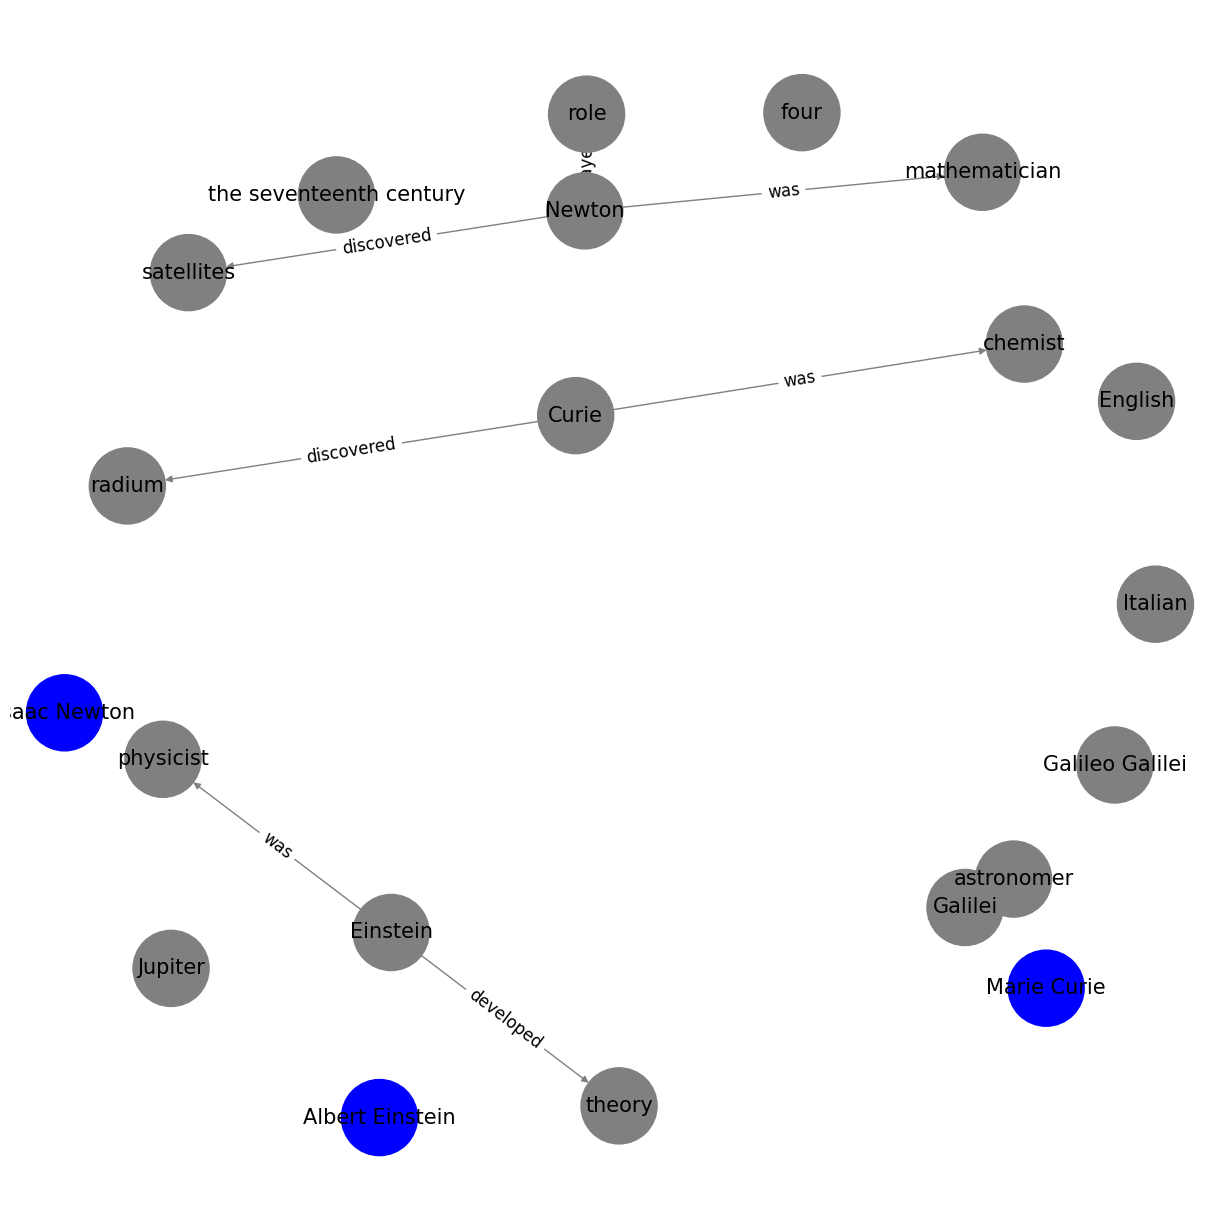

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

def create_kg(entities, relations):
    G = nx.DiGraph()

    for entity, label in entities:
        G.add_node(entity, label=label if label else "UNKNOWN")

    for subj, relation, obj in relations:
        G.add_edge(subj, obj, relation=relation)

    return G


def visualize_kg(G):
    plt.figure(figsize=(12, 12))

    pos = nx.spring_layout(G)

    # Color map based on the label of the node
    color_map = {
        "PERSON": "blue",
        "ORG": "red",
        "GPE": "yellow",
        "CONCEPT": "green",
        "UNKNOWN": "gray"
    }

    # If 'label' is missing for a node, default to "UNKNOWN"
    node_colors = [color_map.get(G.nodes[node].get('label', 'UNKNOWN'), "gray") for node in G.nodes()]

    nx.draw(
        G, pos, with_labels=True, node_color=node_colors,
        edge_color="gray", font_size=15, node_size=3000
    )

    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

    plt.show()

# Ensure you've created the graph G using the `create_kg` function:
# G = create_kg(entities, relations)
visualize_kg(G)

